# Style Transfer based tattoo generation

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import feature

In [6]:
#pre-trained VGG19 model
vgg = models.vgg19(pretrained=True).features

/Users/kovarthanan/Acedamic/City, University of London/INM716 - Industrial AI/INM716_Coursework/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kovarthanan/Acedamic/City, University of London/INM716 - Industrial AI/INM716_Coursework/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/kovarthanan/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [01:18<00:00, 7.28MB/s] 


In [7]:
# Freezing the model
for param in vgg.parameters():
    param.requires_grad_(False)

In [8]:
# Setting up gpu
device = "mps" if torch.mps.is_available() else "cpu"  # If running in mac
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [9]:
def load_image(image_path, max_size=400, shape=None):
    """
    Load and preprocess an image.
    """
    image = Image.open(image_path).convert('RGB')

    # Resize the image while maintaining aspect ratio
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))  # Normalize
    ])

    # Add batch dimension
    image = transform(image).unsqueeze(0).to(device)
    return image

In [10]:
def im_convert(tensor):
    """
    Convert a tensor image back to a numpy array for visualization.
    """
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + \
        np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

In [ ]:
def preprocess_image_for_tattoo(image_path, max_size=400):
    """
    Preprocess the input image by blending edges with the original image.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image
    height, width = image.shape[:2]
    scale = max_size / max(height, width)
    new_height, new_width = int(height * scale), int(width * scale)
    image = cv2.resize(image, (new_width, new_height))

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply Canny edge detection
    edges = feature.canny(gray, sigma=2).astype(np.uint8) * 255

    # Convert edges back to RGB for compatibility
    edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

    # Blend the original image with the edge-detected image
    blended = cv2.addWeighted(image, 0.5, edges_rgb, 0.5, 50)

    # Save the preprocessed image
    preprocessed_path = "preprocessed_input.jpg"
    cv2.imwrite(preprocessed_path, blended)
    return preprocessed_path

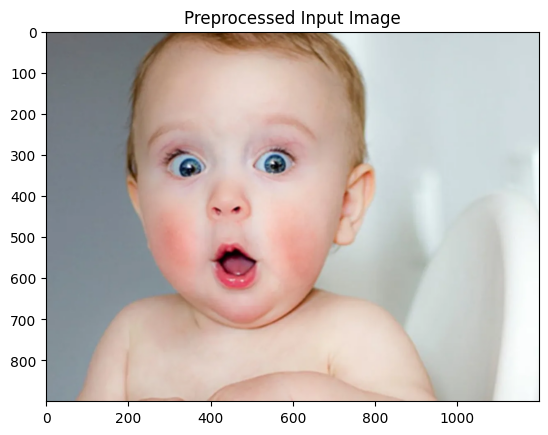

In [28]:
# Preprocess the input image
input_path = "/Users/kovarthanan/Acedamic/City, University of London/INM716 - Industrial AI/INM716_Coursework/Project_02/baby.jpg"
# preprocessed_input = preprocess_image_for_tattoo(input_path)

# Display the preprocessed image
plt.imshow(plt.imread(input_path))
plt.title("Preprocessed Input Image")
plt.show()

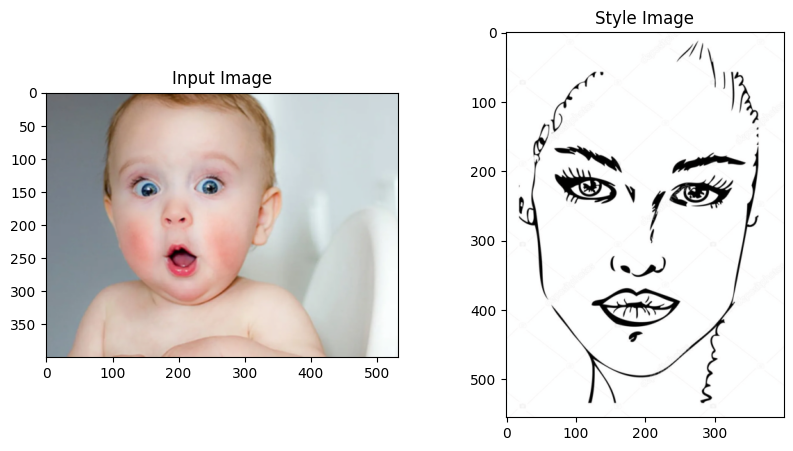

In [30]:
# Load input and style images
# Your input image (e.g., a photograph)
content = load_image(input_path)
content = load_image(input_path)

# Reference tattoo image
style = load_image(
    "/Users/kovarthanan/Acedamic/City, University of London/INM716 - Industrial AI/INM716_Coursework/Project_02/tattoo_style.jpg")

# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(im_convert(content))
ax1.set_title("Input Image")
ax2.imshow(im_convert(style))
ax2.set_title("Style Image")
plt.show()

In [31]:
def get_features(image, model, layers=None):
    """
    Extract features from specific layers of the VGG19 model.
    """
    if layers is None:
        layers = {
            '0': 'conv1_1',   # Content layer
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',  # Style layers
            '21': 'conv4_2',
            '28': 'conv5_1'
        }

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [32]:
def gram_matrix(tensor):
    """
    Compute the Gram matrix for a given tensor.
    """
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [33]:
# Extract features 
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Compute Gram matrices
style_grams = {layer: gram_matrix(
    style_features[layer]) for layer in style_features}

In [34]:
# Initialize the target image 
target = content.clone().requires_grad_(True).to(device)

# Define weights 
style_weights = {'conv1_1': 1.0, 'conv2_1': 0.75,
                 'conv3_1': 0.2, 'conv4_1': 0.2, 'conv5_1': 0.2}
content_weight = 1
style_weight = 1e6

# Optimizer
optimizer = optim.Adam([target], lr=0.003)

In [35]:
# Training loop
steps = 2000  # Number of iterations
for ii in range(1, steps + 1):
    target_features = get_features(target, vgg)

    # Content loss
    content_loss = torch.mean(
        (target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    # Style loss
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * \
            torch.mean((target_gram - style_gram) ** 2)
        style_loss += layer_style_loss / \
            (target_feature.shape[1] * target_feature.shape[2]
             * target_feature.shape[3])

    # Total loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # Update target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Print progress
    if ii % 200 == 0:
        print(f"Iteration {ii}: Total Loss = {total_loss.item()}")

Iteration 200: Total Loss = 354069088.0
Iteration 400: Total Loss = 172303904.0
Iteration 600: Total Loss = 118594624.0
Iteration 800: Total Loss = 93229984.0
Iteration 1000: Total Loss = 75383120.0
Iteration 1200: Total Loss = 61649508.0
Iteration 1400: Total Loss = 50564056.0
Iteration 1600: Total Loss = 41688880.0
Iteration 1800: Total Loss = 34623012.0
Iteration 2000: Total Loss = 29021152.0


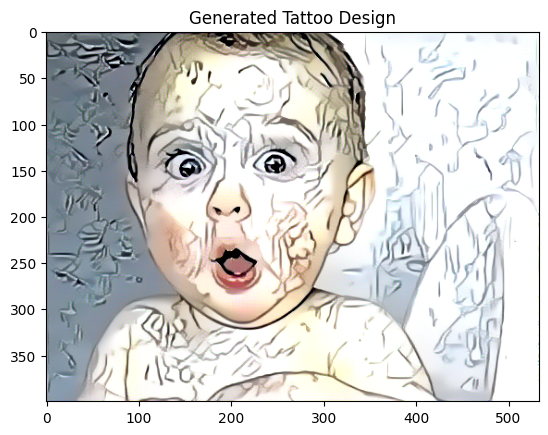

In [36]:
# Display the final result
plt.imshow(im_convert(target))
plt.title("Generated Tattoo Design")
plt.show()